# Logistic Regression with a Neural Network mindset  

<font color='blue'>  

We will build a logistic regression classifier to recognize cats with a Neural Network mindset.  

<font color='blue'>  
- Build the general architecture of a learning algorithm :

    - Initializing parameters
    - Calculating the cost function and its gradient
    - Using an optimization algorithm (gradient descent) 

In [17]:
import os
os.chdir('C:\\Users\\nisha\\Desktop\\Summer Ana')

## 1 - Packages ##
<font color='blue'>  
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test the model with our own picture at the end.

In [18]:
# Importing all the required packages.
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline

## 2 - Overview of the Problem set ##

<font color='blue'>Given a dataset ("data.h5") containing:
 
   - A training set of m_train images labeled as cat (y=1) or non-cat (y=0)
   - A test set of m_test images labeled as cat or non-cat
   - Each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

<font color='blue'>
Goal is to build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.

In [19]:
# Getting more familiar with the dataset.
def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # our train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # our train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # our test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # our test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [20]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

<font color='blue'>  Each line of train_set_x_orig and test_set_x_orig is an array representing an image.

y = [1], it's a 'cat' picture.


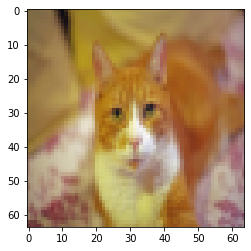

In [21]:
# Visualizing an image
index = 24
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + 
       classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [22]:
# Finding the values
m_train = train_set_x_orig.shape[0]    # number of training examples
m_test = test_set_x_orig.shape[0]      # number of test examples 
num_px = train_set_x_orig.shape[1]     # (Height/Width of a training image)

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


<font color='blue'>For convenience, reshaping the images of shape (num_px, num_px, 3) in a numpy-array of shape (num_px $*$ num_px $*$ 3, 1).
    
After this, our training (and test) dataset is a numpy-array where each column represents a flattened image.<font color='blue'>

A trick to flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b$*$c$*$d, a) is:<font color='blue'>

`X_flatten = X.reshape(X.shape[0], -1).T`


In [23]:
# Reshaping the training and test examples

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0] , -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


In [24]:
# Standardizing the data
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

<font color='blue'>
    
Common steps for pre-processing a new dataset are:
- Figure out the dimensions and shapes of the problem (m_train, m_test, num_px, ...)
- Reshape the datasets such that each example is now a vector of size (num_px \* num_px \* 3, 1)
- "Standardize" the data

## 3 - General Architecture of the learning algorithm ##  

<font color='blue'>  
    
It's time to design a simple algorithm to distinguish cat images from non-cat images.  

We will build a Logistic Regression, using a Neural Network mindset. 

The following Figure explains why **Logistic Regression is actually a very simple Neural Network!**

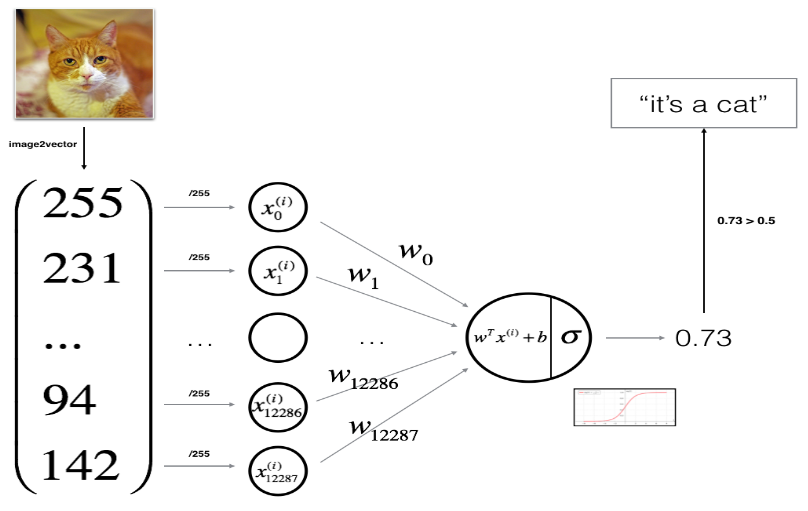

In [25]:
from IPython.display import Image
Image(filename='images/Algorithm_Architecture.png')

<font color='blue'>

**Key steps**:   

   - Initialize the parameters , weights (w) and bias (b) of the model with zeros.  
   - Compute the Activation function (A) and the Final Cost (J) using Forward Propagation.  
   - Compute the gradients w.r.t the weights and the bias using Backward Propagation.  
   - Learn the parameters for the model by minimizing the cost using the gradient descent update rule.  
   - Use the learned parameters to make predictions (on the test set).    
   - Analyse the results and conclude.
   
     Forward Propagation:
- Get X
- Compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- Calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

   Backward Propagation:$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [26]:
# FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    
    # Initialize parameters with zeros
    w = np.zeros((X_train.shape[0],1))
    b = 0 

    # Gradient descent
    costs = []
    
    m = X_train.shape[1]
    
    for i in range(1,num_iterations+1):
        
        # FORWARD PROPAGATION (FROM X TO COST)
        A = 1 / (1 + np.exp(-(np.dot(w.T , X_train) + b)))                                    # compute activation
        cost = -1/m * ((np.dot(Y_train,np.log(A).T)) + (np.dot(1-Y_train,np.log(1-A).T)))     # compute cost
    
        # BACKWARD PROPAGATION (TO FIND GRAD)
        dw = 1/m * np.dot(X_train , (A-Y_train).T)
        db = 1/m * np.sum(A-Y_train)
        
        # update rule  
        w =  w - learning_rate * dw
        b =  b - learning_rate * db
        
        # Record the costs and print the cost every 100 training iterations
        if i % 100 == 0:
            costs.append(cost)
            print ("Cost after iteration %i: %f" %(i, cost))    
    
    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [27]:
# FUNCTION: predict

def predict(w, b, X):
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = 1 / (1 + np.exp(-(np.dot(w.T , X) + b)))
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A[0][i] > 0.5:
            Y_prediction[0][i] = 1
        else:
            Y_prediction[0][i] = 0
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [28]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500 , learning_rate = 0.005, print_cost = True)

Cost after iteration 100: 0.644898
Cost after iteration 200: 0.484894
Cost after iteration 300: 0.377761
Cost after iteration 400: 0.331775
Cost after iteration 500: 0.303529
Cost after iteration 600: 0.280094
Cost after iteration 700: 0.260226
Cost after iteration 800: 0.243100
Cost after iteration 900: 0.228144
Cost after iteration 1000: 0.214944
Cost after iteration 1100: 0.203189
Cost after iteration 1200: 0.192644
Cost after iteration 1300: 0.183124
Cost after iteration 1400: 0.174481
Cost after iteration 1500: 0.166597
train accuracy: 97.60765550239235 %
test accuracy: 70.0 %


y = 0, we predicted that it is a "cat" picture.


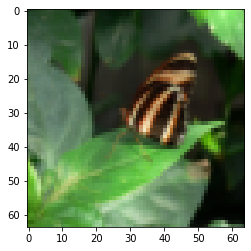

In [29]:
# Example of a picture that was wrongly classified.
index = 5
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", we predicted that it is a \"" + 
       classes[int(d["Y_prediction_test"][0,index])].decode("utf-8") +  "\" picture.")

<font color = 'blue'>
Let's also plot the cost function and the gradients.

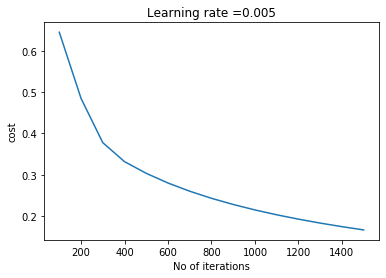

In [30]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(range(100,d["num_iterations"]+100,100) , costs)
plt.ylabel('cost')
plt.xlabel('No of iterations')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

**Interpretation**:<font color = 'blue'>
We can see the cost decreasing. It shows that the parameters are being learned. However, we see that when we increase the number of iterations in the cell , the training set accuracy goes up, but the test set accuracy goes down. This is called overfitting.

#### Choice of learning rate ####

**Reminder**:<font color = 'blue'>
In order for Gradient Descent to work we must choose the learning rate wisely. The learning rate $\alpha$  determines how rapidly we update the parameters. If the learning rate is too large we may "overshoot" the optimal value. Similarly, if it is too small we will need too many iterations to converge to the best values. That's why it is crucial to use a well-tuned learning rate.

Good way to determine is to compare the learning curve of our model with several choices of learning rates.

learning rate is: 0.01
Cost after iteration 100: 0.479341
Cost after iteration 200: 1.817221
Cost after iteration 300: 1.043685
Cost after iteration 400: 0.720906
Cost after iteration 500: 0.460014
Cost after iteration 600: 0.248055
Cost after iteration 700: 0.154733
Cost after iteration 800: 0.135446
Cost after iteration 900: 0.125064
Cost after iteration 1000: 0.116557
Cost after iteration 1100: 0.109261
Cost after iteration 1200: 0.102865
Cost after iteration 1300: 0.097183
Cost after iteration 1400: 0.092092
Cost after iteration 1500: 0.087496
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
Cost after iteration 100: 0.591719
Cost after iteration 200: 0.556098
Cost after iteration 300: 0.529218
Cost after iteration 400: 0.507085
Cost after iteration 500: 0.488058
Cost after iteration 600: 0.471267
Cost after iteration 700: 0.456189
Cost after iteration 800: 0.442481
Cost after iteration 900: 

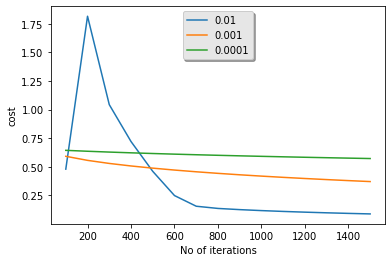

In [31]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    num_iterations = 1500
    models[str(i)] = model(train_set_x, train_set_y, test_set_x,
                           test_set_y, num_iterations = num_iterations, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(range(100,num_iterations + 100,100) , np.squeeze(models[str(i)]["costs"]), 
             label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('No of iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**Interpretation**:<font color = 'blue'> 
- Different learning rates give different costs and thus different predictions results.
- If the learning rate is too large (0.01), the cost may oscillate up and down. It may even diverge (though in this example, using 0.01 still eventually ends up at a good value for the cost). 
- A lower cost doesn't mean a better model. We have to check if there is possibly overfitting. It happens when the training accuracy is a lot higher than the test accuracy.
- In deep learning, usual recommendation is : 
    - Choose the learning rate that better minimizes the cost function.
    - If the model overfits, use other techniques to reduce overfitting.

## 7 - Test with our own image ##  
  
<font color = 'blue'>Now we can use our own image and see the output of your model.
   
Just make sure that you place the image you want to classify in the correct directory.


y = 1.0, Our algorithm predicts a "cat" picture.


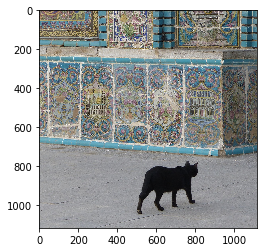

In [32]:
import warnings
warnings.filterwarnings('ignore')

## PUT IMAGE NAME
my_image = "cat_in_iran.jpg" 

# We preprocess the image to fit your algorithm.
fname = "images/" + my_image
image = np.array(plt.imread(fname))
image = image/255.
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", Our algorithm predicts a \"" + 
      classes[int(np.squeeze(my_predicted_image))].decode("utf-8") +  "\" picture.")

**What to remember:**
<font color='blue'>    
1. Preprocessing the dataset is important. 
    
2. Tuning the learning rate (an example of a "hyperparameter") can make a big difference to the algorithm.